In [1]:
import numpy as np
from astropy.table import Table, join
import matplotlib.pyplot as plt
from astropy import units as u

## Test notebook for NGC 4047.  Our x-axis will be the 7" CO intensity from the smoothed mask.  Our y-axis will be the Halpha flux from flux_elines smoothed to 7".

In [2]:
hafile = '../img_califa/NGC4047.pipe3d.hdf5'
cofile = '../img_comom/NGC4047.comom_smo7.hdf5'

In [3]:
cotab=Table.read(cofile, path='smo')
print(cotab)

  Name   ix  iy    ra_off      dec_off    emom0max   mom0    emom0  
                    deg          deg      K km / s K km / s K km / s
------- --- --- ------------ ------------ -------- -------- --------
NGC4047   2   2  0.032772586  -0.02167132      nan      nan      nan
NGC4047   2   5   0.03277313 -0.020837985      nan      nan      nan
NGC4047   2   8   0.03277367 -0.020004652      nan      nan      nan
NGC4047   2  11   0.03277421 -0.019171318      nan      nan      nan
NGC4047   2  14   0.03277475 -0.018337986      nan      nan      nan
NGC4047   2  17   0.03277529 -0.017504651      nan      nan      nan
NGC4047   2  20  0.032775834 -0.016671319      nan      nan      nan
NGC4047   2  23  0.032776374 -0.015837986      nan      nan      nan
NGC4047   2  26  0.032776915 -0.015004652      nan      nan      nan
NGC4047   2  29  0.032777455 -0.014171319      nan      nan      nan
    ... ... ...          ...          ...      ...      ...      ...
NGC4047 158 131  -0.03279587  0.01

In [4]:
hatab=Table.read(hafile, path='flux_elines_sm')
print(hatab)

  Name   ix  iy    ra_off    ... e_EW_[NII]6548 e_EW_[SII]6717 e_EW_[SII]6731
                    deg      ...    Angstrom       Angstrom       Angstrom   
------- --- --- ------------ ... -------------- -------------- --------------
NGC4047   2   2  0.032772586 ...            nan            nan            nan
NGC4047   2   5   0.03277313 ...            nan            nan            nan
NGC4047   2   8   0.03277367 ...            nan            nan            nan
NGC4047   2  11   0.03277421 ...            nan            nan            nan
NGC4047   2  14   0.03277475 ...            nan            nan            nan
NGC4047   2  17   0.03277529 ...            nan            nan            nan
NGC4047   2  20  0.032775834 ...            nan            nan            nan
NGC4047   2  23  0.032776374 ...            nan            nan            nan
NGC4047   2  26  0.032776915 ...            nan            nan            nan
NGC4047   2  29  0.032777455 ...            nan            nan  

In [5]:
jointbl = join(cotab,hatab)

In [6]:
print(jointbl.colnames)

['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'emom0max', 'mom0', 'emom0', 'flux_[OII]3727', 'flux_[OIII]5007', 'flux_[OIII]4959', 'flux_Hbeta', 'flux_Halpha', 'flux_[NII]6583', 'flux_[NII]6548', 'flux_[SII]6717', 'flux_[SII]6731', 'vel_[OII]3727', 'vel_[OIII]5007', 'vel_[OIII]4959', 'vel_Hbeta', 'vel_Halpha', 'vel_[NII]6583', 'vel_[NII]6548', 'vel_[SII]6717', 'vel_[SII]6731', 'disp_[OII]3727', 'disp_[OIII]5007', 'disp_[OIII]4959', 'disp_Hbeta', 'disp_Halpha', 'disp_[NII]6583', 'disp_[NII]6548', 'disp_[SII]6717', 'disp_[SII]6731', 'EW_[OII]3727', 'EW_[OIII]5007', 'EW_[OIII]4959', 'EW_Hbeta', 'EW_Halpha', 'EW_[NII]6583', 'EW_[NII]6548', 'EW_[SII]6717', 'EW_[SII]6731', 'e_flux_[OII]3727', 'e_flux_[OIII]5007', 'e_flux_[OIII]4959', 'e_flux_Hbeta', 'e_flux_Halpha', 'e_flux_[NII]6583', 'e_flux_[NII]6548', 'e_flux_[SII]6717', 'e_flux_[SII]6731', 'e_vel_[OII]3727', 'e_vel_[OIII]5007', 'e_vel_[OIII]4959', 'e_vel_Hbeta', 'e_vel_Halpha', 'e_vel_[NII]6583', 'e_vel_[NII]6548', 'e_vel_[SII]6717', 'e_vel

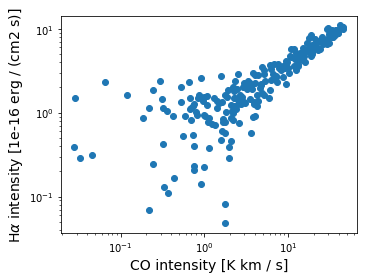

In [7]:
plt.loglog(jointbl['mom0'],jointbl['flux_Halpha'],ls='None',marker='o')
plt.xlabel('CO intensity ['+str(jointbl['mom0'].unit)+']',fontsize=14)
plt.ylabel(r'H$\alpha$ intensity ['+str(jointbl['flux_Halpha'].unit)+']',fontsize=14)
plt.gca().set_aspect('equal')

In [8]:
# Convert Halpha intensity to SFR surface density
def sfr_ha(flux_ha, flux_hb):
    # Extinction curve from Cardelli+(1989).
    K_Ha = 2.53
    K_Hb = 3.61
    # Eq(1) from Catalan-Torrecilla+(2015). 
    A_Ha = K_Ha/(-0.4*(K_Ha-K_Hb)) * np.log10((flux_ha/flux_hb)/2.86)
    A_Ha[A_Ha < 0] = 0.
    flux_ha_cor = flux_ha * 10**(0.4*A_Ha)
    # line flux is actually flux per arcsec2
    sterad = (u.sr/u.arcsec**2).decompose()   # 206265^2
    sb_ha  = flux_ha_cor * sterad   # flux per steradian
    lsd_ha = 4*np.pi * sb_ha
    # Eq(4) from Catalan-Torrecilla+(2015).
    lumcon = 5.5e-42 * (u.solMass/u.yr) / (u.erg/u.s)
    sigsfr = (lumcon * lsd_ha).to(u.solMass/(u.pc**2*u.Gyr))
    return sigsfr

In [9]:
# Convert CO intensity to H2(+He) surface density
def msd_co(sb_co, alphaco=4.3):
    convfac = alphaco * (u.solMass/u.pc**2) / (u.K*u.km/u.s)
    sig_mol = (convfac*sb_co).to(u.solMass/u.pc**2)
    return sig_mol

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


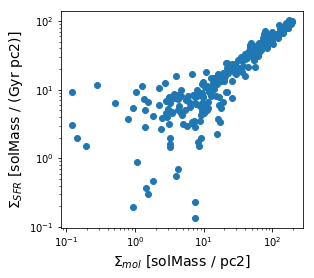

In [10]:
sig_sfr = sfr_ha(jointbl['flux_Halpha'],jointbl['flux_Hbeta'])
sig_mol = msd_co(jointbl['mom0'])
plt.loglog(sig_mol,sig_sfr,ls='None',marker='o')
plt.xlabel(r'$\Sigma_{mol}$ ['+str(sig_mol.unit)+']',fontsize=14)
plt.ylabel(r'$\Sigma_{SFR}$ ['+str(sig_sfr.unit)+']',fontsize=14)
plt.gca().set_aspect('equal')